In [1]:
import math as m
import numpy as np
import pandas as pd
import linecache

import scipy.interpolate as int1d
from scipy.sparse import *
from scipy.linalg.lapack  import  dgtsv  as  lapack_dgtsv

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import time, sys

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import matplotlib.ticker as ticker
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rc('text', usetex=True)  # switch to True for latex font (might be slow)
rcParams.update({"xtick.major.size": 6, "xtick.minor.size": 3, "ytick.major.size": 6, "ytick.minor.size": 3, 
                 'xtick.direction': 'in', 'ytick.direction': 'in', 'xtick.top': True, 'ytick.right': True, 
                 'font.size': 16})

# RANS solver for fully developed compressible turbulent channel flows
 
             Created on: Dec, 2018
                Authors: Rene Pecnik (R.Pecnik@tudelft.nl)
                         Gustavo J. Otero R. (G.J.OteroRodriguez@tudelft.nl)
                         Process & Energy Department, Faculty of 3mE
                         Delft University of Technology, the Netherlands.

       Last modified on: Dec, 2018
                     by: Rene Pecnik 
                     
The detailed derivation and implementation, including the compressiblity corrections for several turbulence models, is outlined in the corresponding publication: 
 * __[Otero et al., 2017. Heat and fluid flow](https://www.sciencedirect.com/science/article/pii/S0142727X18301978)__, 

## Velocity transformations

#### Van Driest velocity transformation

$$ u^{vD} = \int_0^{u^+} \sqrt{\frac{\rho}{\rho_w}}d u^+$$

#### Velocity transformation based on semi-local scaling, Patel et al., 2016, JFM

$$ u^\star = \int_0^{u^{vD}} \left[1 + \frac{y}{Re_\tau^\star}\frac{d Re_\tau^\star}{dy} \right]d u^{vD}$$

In [2]:
def velTransVD(upl,rho,ReTau,mesh):

    n   = mesh.n
    uvd = np.zeros(n)
    ypl = mesh.y*ReTau
    
    for i in range(1,n):
        uvd[i] = uvd[i-1] + np.sqrt(0.5*(rho[i]+rho[i-1])/rho[0])*(upl[i]-upl[i-1])
        
    return ypl,uvd

def velTransSLS(upl,rho,mu,ReTau,mesh):

    n = mesh.n

    # Calculate correction factor of semi-local velocity transformation
    ReTauStar = ReTau*np.sqrt(rho/rho[0])/(mu/mu[0])
    fact      = 1 + mesh.y/ReTauStar*(mesh.ddy@ReTauStar)

    ystar = mesh.y*ReTauStar
    ypl, uvd = velTransVD(upl,rho,ReTau,mesh)
    
    ustar = np.zeros(n)
    for i in range(1,n):
        ustar[i] = ustar[i-1] + 0.5*(fact[i]+fact[i-1])*(uvd[i]-uvd[i-1])

    return ystar,ustar

## Mesh 
### Mesh and derivative matrices

     y=0                           y=H/2                         y=H
     
       || |  |   |    |      |      |      |      |    |   |  | ||
       xx x  x   x    x      x      x      x      x    x   x  x xx
       || |  |   |    |      |      |      |      |    |   |  | ||
       

Inputs:
*   n        number of mesh points (nodes)
*   H        channel height
*   fact     factor to set mesh clustering at the wall

MESH class contains: 
  *  'y'      ... y coordinates  
  *  'ddy'    ... first derivative coefficient matrix d()/dy
  *  'd2dy2'  ... second derivative coefficient matrix d2()/dy2

### Function to solve linear system with under-relaxation

The linear system is
$$ Ax = b $$
Using an under-relaxation parameter $\omega$, the system can also be written as
$$ \left(A - \frac{1-\omega}{\omega}A_{ii}\right)x_{new} = b - \frac{1-\omega}{\omega}A_{ii}x_{old} $$


In [3]:
def finiteDiffCoeff(x,k):

    x = np.array(x)
    n = np.size(x)
    A = np.ones((n,n))

    for i in range(1, n):
        A[i,:] = pow(x,i)/m.factorial(i)

    b = np.zeros((n,1))            # b is right hand side,
    b[k] = 1                       # so k'th derivative term remains
    sol  = np.linalg.solve(A, b)   # solve system for coefficients
    return sol.transpose()


class Mesh:

    def __init__(self, n, H, fact):

        self.n = n

        di = 1.0/(n-1)
        i = (np.linspace(0,n-1,n))/(n-1) - 0.5
        
        # y - coordinate: tanh clustering at the walls
        self.y = H * (1.0 + np.tanh(fact*i)/np.tanh(fact/2))/2.0
        
        # first derivative of y with respect to 'i'
        dydi =  H * fact/2.0/np.tanh(fact/2)/np.power(np.cosh(fact*i), 2.0)
        
        # second derivative of y with respect to 'i'
        d2ydi2 = -H * np.power(fact,2.0)/np.tanh(fact/2)*np.tanh(fact*i)/np.power(np.cosh(fact*i),2.0)
                
        # ---------------------------------------------------------------------------------------------------
        #
        # First derivative: coefficient matrix for d()/dy = 1/(dy/di) * d()/di
        #
        ddy                = np.zeros((n,n))
        ddy[0,  0:7]       = finiteDiffCoeff(np.arange( 0,7), 1) # higher-order, one-sided at the boundary
        ddy[n-1,n-7:n]     = finiteDiffCoeff(np.arange(-6,1), 1) # higher-order, one-sided at the boundary
        for i in range(1,n-1):
            ddy[i,i-1:i+2] = [-0.5, 0, 0.5]                      # second order for all points within the domain 
        self.ddy = diags(1/di/dydi)@csr_matrix(ddy)              # multiply coordinate transf. and convert to sparse matrix

        
        # ---------------------------------------------------------------------------------------------------
        #
        # Second derivative: coefficient matrix for d2()/dy2 = 1/(dy/di)^2*d2()/di2 - 1/(dy/di)^3*d2y/di2*d()/di
        #
        d2dy2                = np.zeros((n,n))
        d2dy2[0,  0:7  ]     = finiteDiffCoeff(np.arange( 0,7), 2)   # higher-order, one-sided at the boundary
        d2dy2[n-1,n-7:n]     = finiteDiffCoeff(np.arange(-6,1), 2)   # higher-order, one-sided at the boundary
        for i in range(1,n-1):
            d2dy2[i,i-1:i+2] = [ 1., -2.,  1.]                       # second order for all points within the domain 
        self.d2dy2 = diags(1/(di*dydi)**2.0)@csr_matrix(d2dy2) - diags(d2ydi2/dydi**2).dot(self.ddy)


    def solveEqn(self,x,A,b,omega):

        x_new = x.copy()

        b[0]  -= x[0]*A[1,0]     # boundary condition at y=0
        b[-1] -= x[-1]*A[-2,-1]  # boundary condition at y=H

        if (omega < 1.0):
            b[:] += (1-omega)/omega * A.diagonal()[1:-1]*x[1:-1]
            A.setdiag(A.diagonal()/omega)

        # x_new[1:-1] = linalg.spsolve(A[1:-1, 1:-1], b)
        
        x_new[1:-1] = lapack_dgtsv(A.diagonal(-1)[1:-1],
                                   A.diagonal( 0)[1:-1],
                                   A.diagonal( 1)[1:-1], b)[-2]

        return x_new

# Momentum equation (fully developed channel)
The streamwise momentum equation of the Reynolds-averaged Navier-Stokes equations for a fully developed turbulent channel flow reads, 

$$ \frac{d}{dy}\left[\left(\mu+\mu_t \right) \frac{du}{dy}\right] = -1,$$ 

with $u$ the streamwise velocity, $\mu$ the dynamic visocity, and $\mu_t$ the Eddy viscosity which is obtained by a solving a turbulence model. Wall units are used to non-dimensionalize the Navier-Stokes equations, hence $-1$ defines the forcing on the right-hand-side. 
Using the product rule, the momentum equation can also be written as 
$$ \left[\frac{d\mu_{eff}}{dy}\frac{d}{dy} + \mu_{eff}\frac{d^2}{dy^2}\right] u = -1, $$ 

with $\mu_{eff} = \mu+\mu_t$. Now it is easy to formulate a linear system $ A u = -1 $ which can be solved using a direct linear solver. 

In [4]:
def solveRANS(mesh  = Mesh(200, 2, 5),      # provide mesh 
              ReTau = 1000,                 # ReTau
              turbModel = "SA",             # pass string for turbulence model 
              varPropCorrection = "None",   # variable property correction: "OteroEtAl", CatrisAupoix", "None"
              yDNS = [],                    # if yDNS not empty, then use rho and mu from DNS and do not solve temperature eq. 
              rhoDNS = [],                  #   - rho from DNS 
              muDNS = [],                   #   - mu from DNS 
              Pr = 1.0,                     # if yDNS empty, then solve temperature eq. using the following values: Pr
              Prt = 1.0,                    #   - Prt: turbulent Prandtl number
              expRho = 0.0,                 #   - expRho, exponent: rho = T**expRho
              expMu = 0.0,                  #   - expMu,  exponent: mu  = T**expMu
              expLam = 0.0,                 #   - expLam, exponent: lam = T**expLam
              Qvol = 0.0,                   #   - Qvol, heat source for Patel et al. cases 
              verbose = False):             # provide more output if verbose is True

    n    = mesh.n
    u    = np.zeros(n)          # velocity 
    T    = np.ones(n)           # temperature 

    mut  = np.zeros(n)          # eddy viscosity 
    k    = 0.01*np.ones(n)      # turbulent kinetic energy
    e    = 0.001*np.ones(n)     # turbulent dissipation 
    v2   = 1/3*k                # wall normal turbulent fluctuations for V2F model
    om   = np.ones(n)           # specific turbulent dissipation for omega in SST
    nuSA = np.ones(n)/ReTau     # eddy viscisty for SA model

    # if yDNS not empty, use rho and mu from DNS. Interpolate on mesh
    if (len(yDNS) != 0):        
        rho = np.interp(np.minimum(mesh.y, mesh.y[-1]-mesh.y), yDNS, rhoDNS);  rho[0] = rho[-1] = 1.0
        mu  = np.interp(np.minimum(mesh.y, mesh.y[-1]-mesh.y), yDNS, muDNS );   mu[0] =  mu[-1] = 1.0/ReTau

    
    residual   = 1.0e20
    iterations = 0
    
    if (verbose == True): print("Start iterating")

    tic = time.perf_counter()

    while residual > 1.0e-6 and iterations < 10000:

        # Solve temperature:  d/dy[(lam+mut/PrT)dTdy] = -VolQ/ReTau/Pr
        if (len(yDNS) == 0):
            rho, mu, T = solveTemperature(T, mut, ReTau, Pr, Prt, expRho, expMu, expLam, Qvol, mesh)

        # Solve turbulence model to calculate eddy viscosity 
        if   turbModel == "SA":  mut,nuSA   = SA( u, nuSA,          rho, mu,        mesh, varPropCorrection)
        elif turbModel == "MK":  mut,k,e    = MK( u, k,    e,       rho, mu, ReTau, mesh, varPropCorrection)
        elif turbModel == "SST": mut,k,om   = SST(u, k,    om,      rho, mu,        mesh, varPropCorrection)
        elif turbModel == "V2F": mut,k,e,v2 = V2F(u, k,    e,  v2,  rho, mu,        mesh, varPropCorrection)
        else:                    mut        = np.zeros(n)

        # Solve momentum equation:  0 = d/dy[(mu+mut)dudy] - 1
        # diffusion matrix: mueff*d2phi/dy2 + dmueff/dy dphi/dy
        mueff = mu + mut
        A = diags(mesh.ddy@mueff).dot(mesh.ddy) + diags(mueff).dot(mesh.d2dy2)

        # Solve 
        u_old    = u.copy()
        u        = mesh.solveEqn(u, A, -np.ones(n-2), 1.0)
        residual = np.linalg.norm(u-u_old)/n

        # Printing residuals
        if (iterations%100 == 0 and verbose == True): print("iteration: ",iterations, ", Residual(u) = ", residual)
        iterations = iterations + 1

    toc = time.perf_counter()

    if residual > 1.0e-6:
        print(f"NOT CONVERGED! Iteration: {iterations}, Residual(u) = {residual}, Time to run {toc - tic:0.4f} seconds")
    else:
        print(f"CONVERGED! Iteration: {iterations}, Residual(u) = {residual}, Time to run {toc - tic:0.4f} seconds")

    ypl,uvd =  velTransVD(u,  rho,   ReTau, mesh)      # note, u is already u+ due to normalization
    yst,ust = velTransSLS(u, rho, mu,ReTau, mesh)
    ruv     = -mut*(mesh.ddy@u)

    return {'ypl':ypl, 'yst':yst, 'u':u, 'uvd':uvd, 'ust':ust, 
            'T':T, 'rho':rho, 'mu':mu, 
            'mut':mut, 'ruv':ruv, 'k':k, 'e':e, 'om':om}

# Temperature equation

The temperature equation (normalized by the wall temperature) for a fully developed channel reads

$$\frac{d}{dy}\left[\left(\lambda+\frac{\mu_t}{Pr_t}\right)\frac{dT}{dy}\right] = -\frac{Q}{Re_\tau Pr}, $$ 

with $\lambda$ the thermal conductivity, $Pr_t$ the turbulent Prandtl number, $Q$ the volumetric heat source, and $Re_\tau$ and $Pr$ the reference Reynolds and Prandtl numbers, respectively. The boundary conditions for the normalized temperature at both walls is 1. Using the temperature, the density $\rho$, dynamic viscosity $\mu$ and thermal conductivity $\lambda$ are then calculated as follows, 
* thermal conductivity: $$\lambda = \frac{T^\mathrm{expLam}}{Re_\tau Pr},$$
* density:  $$\rho = T^\mathrm{expRho},$$
* viscosity: $$\mu = \frac{T^\mathrm{expMu}}{Re_\tau}.$$

The exponents determine the relation of these quantities with temperature. If the purpose is to compare the RANS solution with results from DNS, then the exponents, the reference Reynolds and Prandtl numbers, and the volumetric heat source can be found in the DNS data files in line 39.

In [5]:
def solveTemperature(T, mut, ReTau, Pr, Prt, expRho, expMu, expLam, Qvol, mesh):
    
    n = mesh.n
    
    # molecular thermal conductivity: 
    lam = np.power(T, expLam)/(ReTau*Pr)   
    
    # turbulent Prandtl: assume = 1
    Prt = Prt * np.ones(n)                          

    # diffusion matrix: lamEff*d2phi/dy2 + dlamEff/dy dphi/dy
    lam_eff = lam + mut/Prt   
    A = diags(mesh.ddy@lam_eff).dot(mesh.ddy) + diags(lam_eff).dot(mesh.d2dy2)

    # Isothermal BC
    T[0] = T[-1] = 1              
    
    # source term
    b = -Qvol*np.ones(n-2)/(ReTau*Pr)

    # Solve
    T = mesh.solveEqn(T, A, b, 0.95)

    # calculate density and viscosity from temperature
    r  = np.power(T, expRho)
    mu = np.power(T, expMu)/ReTau
    
    return r, mu, T

# Turbulence models

### Spalart & Allmaras model, 'SA': 
Spalart, A. and Allmaras, S., "One equation turbulence model for aerodynamic flows", Recherche Aerospatiale-French edition, 1994.
> Turbulent scalar equation $\tilde \nu$: $$0 = c_{b1} \hat S \tilde\nu - c_{w1} f_w \left(\frac{\tilde\nu}{y}\right)^2 + \frac{1}{{\color{red}{\rho}}c_{b3}} \frac{d}{dy}\left[{\color{red}{\rho}}\left(\nu+\tilde\nu\right) \frac{d \tilde\nu}{dy} + {\color{red}{\left(\nu+\tilde\nu\right) \frac{\tilde\nu}{2}\frac{d \rho}{dy}}}\right] + \frac{c_{b2}}{{\color{red}{\rho}}c_{b3}} \left(\frac{d {\color{red}{\sqrt{\rho}}}\tilde\nu}{dy}\right)^2 $$
with the eddy viscosity $$ \mu_t = \rho \tilde\nu f_{v1}$$

The changes for the compressiblity correction are indicated in red. 

In [6]:
def SA(u,nuSA,r,mu,mesh,varPropCorrection):
    
    n = mesh.n

    # Model constants
    cv1_3   = np.power(7.1, 3.0)
    cb1     = 0.1355
    cb2     = 0.622
    cb3     = 2.0/3.0
    inv_cb3 = 1.0/cb3
    kappa_2 = np.power(0.41, 2.0)
    cw1     = cb1/kappa_2 + (1.0+cb2)/cb3
    cw2     = 0.3
    cw3_6   = np.power(2.0, 6.0)
    
    # Model functions
    # vort rate = strain rate in fully developed channel
    strMag        = np.absolute(mesh.ddy@u)   
    wallDist      = np.minimum(mesh.y, mesh.y[-1]-mesh.y) 
    wallDist      = np.maximum(wallDist, 1.0e-8)
    inv_wallDist2 = 1/np.power(wallDist, 2)

    chi           = nuSA*r/mu
    fv1           = np.power(chi, 3)/(np.power(chi, 3) + cv1_3)
    fv2           = 1.0 - (chi/(1.0+(chi*fv1)))
    inv_kappa2_d2 = inv_wallDist2*(1.0/kappa_2)
    Shat          = strMag + inv_kappa2_d2*fv2*nuSA
    inv_Shat      = 1.0/Shat
    r_SA          = np.minimum(nuSA*inv_kappa2_d2*inv_Shat, 10.0)
    g             = r_SA + cw2*(np.power(r_SA, 6) - r_SA)
    g_6           = np.power(g, 6)
    fw_           = np.power(((1.0 + cw3_6)/(g_6+ cw3_6)), (1/6))
    fw            = g*fw_

    # Eddy viscosity
    mut       = np.zeros(n)
    mut[1:-1] = fv1[1:-1]* nuSA[1:-1]*r[1:-1]
    mut[1:-1] = np.minimum(np.maximum(mut[1:-1], 0.0), 100.0)
    
    if varPropCorrection == "None":
        nueff = (mu/r + nuSA)
        fs    = np.ones(n)
        fd    = np.ones(n)
        drho  = np.zeros(n)
        
    elif varPropCorrection == "OteroEtAl":
        nueff = (mu/r + nuSA)*r
        fs    = np.sqrt(r)
        fd    = 1/r
        drdy  = mesh.ddy@r
        Di    = nueff*nuSA*drdy
        drho  = 0.5*inv_cb3/r*(mesh.ddy@Di)
    else: 
        print("varPropCorrection = {varPropCorrection} not implemented! Abort.")
        sys.exit(0)


    # ---------------------------------------------------------------------
    # nuSA-equation 
    
    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy
    A = diags(nueff*fd)@mesh.d2dy2 + diags((mesh.ddy@nueff)*fd)@mesh.ddy
    A = inv_cb3*A
    
    # implicitly treated source term
    A -= diags(cw1*fw*nuSA*inv_wallDist2)

    # Right hand side
    dnudy = mesh.ddy@(fs*nuSA)
    b  = - cb1*Shat[1:-1]*nuSA[1:-1] - cb2*inv_cb3*np.power(dnudy[1:-1], 2) - drho[1:-1]
    
    # Wall boundary conditions
    nuSA[0] = nuSA[-1] = 0.0

    # Solve
    nuSA = mesh.solveEqn(nuSA, A, b, 0.85)
    nuSA[1:-1] = np.maximum(nuSA[1:-1], 1.e-12)

    return mut,nuSA

### Myong & Kasagi $k-\varepsilon$ model, 'MK': 
Myong, H.K. and Kasagi, N., "A new approach to the improvement of k-epsilon turbulence models for wall bounded shear flow", JSME, 1990.
> Turbulent kinetic energy $k$:  $$ 0 = P_k - \rho \varepsilon + {\color{red}{\frac{1}{\sqrt\rho}}}\frac{d}{dy}\left[{\color{red}{\frac{1}{\sqrt\rho}}}\left(\mu+\mu_t/\sigma_k\right) \frac{d {{\color{red}{\rho}}}k}{dy}\right] $$
 Turbulent dissipation $\varepsilon$: $$ 0 = \frac{\varepsilon}{k}\left(C_{\varepsilon 1} f_1 P_k - C_{\varepsilon 2} f_2 \varepsilon\right) + {\color{red}{\frac{1}{\rho}}}\frac{d}{dy}\left[{\color{red}{\frac{1}{\sqrt\rho}}}\left(\mu+\mu_t/\sigma_\varepsilon\right)\frac{d {\color{red}{\rho^{3/2}}}\varepsilon}{dy}\right] $$
 with the eddy viscosity $$ \mu_t = C_\mu f_\mu \rho \frac{k^2}{\varepsilon}$$
 
 The changes for the compressiblity correction are indicated in red. 

In [7]:
def MK(u,k,e,r,mu,ReTau,mesh,varPropCorrection):

    n = mesh.n
    d = np.minimum(mesh.y, mesh.y[-1]-mesh.y) 
    
    # if compressibleCorrection == 1:
    yplus = d*np.sqrt(r/r[0])/(mu/mu[0])*ReTau
    # else: 
    #     yplus = d*ReTau
    
    # Model constants
    cmu  = 0.09 
    sigk = 1.4 
    sige = 1.3 
    Ce1  = 1.4 
    Ce2  = 1.8
    
    # Model functions 
    ReTurb  = np.minimum(np.maximum(r*np.power(k, 2)/(mu*e), 1.0e-8), 1e6)
    f2      = (1-2/9*np.exp(-np.power(ReTurb/6, 2)))*np.power(1-np.exp(-yplus/5), 2)
    fmue    = (1-np.exp(-yplus/70))*(1.0+3.45/np.power(ReTurb, 0.5))
    fmue[0] = fmue[-1] = 0.0

    # eddy viscosity
    mut  = cmu*fmue*r/e*np.power(k,2)
    mut[1:-1] = np.minimum(np.maximum(mut[1:-1],1.0e-10),100.0)

    # Turbulent production: Pk = mut*dudy^2
    Pk = mut*np.power(mesh.ddy@u, 2)

    
    # ---------------------------------------------------------------------
    # e-equation
    
    # effective viscosity
    if varPropCorrection == "None":
        mueff = mu + mut/sige
        fs = fd = np.ones(n)
    elif varPropCorrection == "OteroEtAl":
        mueff = (mu + mut/sige)/np.sqrt(r)
        fs = np.power(r, 1.5)
        fd = 1/r
    else:
        print("varPropCorrection = {varPropCorrection} not implemented! Abort.")
        sys.exit(0)

    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy
    A = diags(mueff*fd)@mesh.d2dy2 + diags((mesh.ddy@mueff)*fd)@mesh.ddy

    # Left-hand-side, implicitly treated source term
    A -= diags(Ce2*f2*r*e/np.maximum(k, 1.0e-12)/fs)
        
    # Right-hand-side
    b = -e[1:-1]/k[1:-1]*Ce1*Pk[1:-1]
    
    # Wall boundary conditions
    e[0 ] = mu[ 0]/r[ 0]*k[ 1]/np.power(d[ 1], 2)
    e[-1] = mu[-1]/r[-1]*k[-2]/np.power(d[-2], 2)

    # Solve eps equation
    e = mesh.solveEqn(e*fs, A, b, 0.8)/fs
    e[1:-1] = np.maximum(e[1:-1], 1.e-12)
    

    # ---------------------------------------------------------------------
    # k-equation

    # effective viscosity
    if varPropCorrection == "None":
        mueff = mu + mut/sigk
        fs = fd = np.ones(n)
    elif varPropCorrection == "OteroEtAl":
        mueff = (mu + mut/sigk)/np.sqrt(r)
        fs = r
        fd = 1/np.sqrt(r)
    else:
        print("varPropCorrection = {varPropCorrection} not implemented! Abort.")
        sys.exit(0)

    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy
    A = diags(mueff*fd)@mesh.d2dy2 + diags((mesh.ddy@mueff)*fd)@mesh.ddy
        
    # implicitly treated source term
    A -= diags(r*e/np.maximum(k, 1.0e-12)/fs)
    
    # Right-hand-side
    b  = -Pk[1:-1]
    
    # Wall boundary conditions
    k[0] = k[-1] = 0.0
    
    # Solve TKE
    k = mesh.solveEqn(k*fs, A, b, 0.7)/fs
    k[1:-1] = np.maximum(k[1:-1], 1.e-12)

    return mut,k,e

### Menter's $k-\omega$, 'SST': 
Menter, F.R., "Zonal Two equation k-omega turbulence models for aerodynamic flows", AIAA 93-2906, 1993.
> Turbulent kinetic energy $k$: $$0 = P_k - \beta^\star \rho k \omega + {\color{red}{\frac{1}{\sqrt\rho}}}\frac{d}{dy}\left[{\color{red}{\frac{1}{\sqrt\rho}}}\left(\mu+\mu_t/ \sigma_k\right) \frac{d {\color{red}{\rho}}k}{dy}\right]$$  
  Specific turbulent dissipation $\omega$: $$ 0 = \rho\frac{\alpha P_k}{\mu_t} - \beta \rho \omega^2 + \frac{d}{dy}\left[{\color{red}{\frac{1}{\sqrt\rho}}}\left(\mu+\mu_t \sigma_\omega\right) \frac{d {\color{red}{\sqrt\rho}}\omega}{dy}\right] + \left(1-F_1\right) CD_{k\omega}$$
 with the eddy viscosity: $$\mu_t = \rho k ~\mathrm{min} \left(\frac{1}{\omega}, \frac{a_1}{\|S\| F_2} \right)$$
 
The changes for the compressiblity correction are indicated in red. 

In [8]:
def SST(u,k,om,r,mu,mesh,varPropCorrection):

    n = mesh.n

    # model constants
    sigma_k1  = 0.85
    sigma_k2  = 1.0
    sigma_om1 = 0.5
    sigma_om2 = 0.856
    beta_1    = 0.075
    beta_2    = 0.0828
    betaStar  = 0.09
    a1        = 0.31
    alfa_1    = beta_1/betaStar - sigma_om1*0.41**2.0/betaStar**0.5
    alfa_2    = beta_2/betaStar - sigma_om2*0.41**2.0/betaStar**0.5    
    
    # Relaxation factors
    underrelaxK  = 0.8
    underrelaxOm = 0.8
        
    # required gradients
    dkdy  = mesh.ddy@k
    domdy = mesh.ddy@om
    
    wallDist = np.minimum(mesh.y, mesh.y[-1]-mesh.y) 
    wallDist = np.maximum(wallDist, 1.0e-8)


    # VortRate = StrainRate in fully developed channel
    strMag = np.absolute(mesh.ddy@u) 
    
    # Blending functions 
    CDkom  = 2.0*sigma_om2*r/om*dkdy*domdy
    gamma1 = 500.0*mu/(r*om*wallDist*wallDist)
    gamma2 = 4.0*sigma_om2*r*k/(wallDist*wallDist*np.maximum(CDkom,1.0e-20))
    gamma3 = np.sqrt(k)/(betaStar*om*wallDist)
    gamma  = np.minimum(np.maximum(gamma1, gamma3), gamma2)
    bF1    = np.tanh(np.power(gamma, 4.0))
    gamma  = np.maximum(2.0*gamma3, gamma1)
    bF2    = np.tanh(np.power(gamma, 2.0))

    # more model constants
    alfa     = alfa_1*bF1    + (1-bF1)*alfa_2
    beta     = beta_1*bF1    + (1-bF1)*beta_2
    sigma_k  = sigma_k1*bF1  + (1-bF1)*sigma_k2
    sigma_om = sigma_om1*bF1 + (1-bF1)*sigma_om2
    
    # Eddy viscosity
    zeta = np.minimum(1.0/np.maximum(om,1e-12), a1/np.maximum(strMag*bF2, 1e-12))
    mut = r*k*zeta
    mut = np.minimum(np.maximum(mut,0.0),100.0)
    
    # ---------------------------------------------------------------------
    # om-equation
    
    # effective viscosity
    if varPropCorrection == "None":
        mueff = mu + sigma_om*mut
        fs    = np.ones(n)
    elif varPropCorrection == "OteroEtAl":
        mueff = (mu + sigma_om*mut)/np.sqrt(r)
        fs    = np.sqrt(r)
    else:
        print("varPropCorrection = {varPropCorrection} not implemented! Abort.")
        sys.exit(0)

    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy
    A = diags(mueff)@mesh.d2dy2 + diags((mesh.ddy@mueff))@mesh.ddy
    
    # implicitly treated source term
    A -= diags(beta*r*om/fs)

    # Right-hand-side
    b = -alfa[1:-1]*r[1:-1]*strMag[1:-1]*strMag[1:-1] - (1-bF1[1:-1])*CDkom[1:-1]
    
    # Wall boundary conditions
    om[0 ] = 60.0*mu[0 ]/beta_1/r[0 ]/wallDist[1 ]/wallDist[1 ]
    om[-1] = 60.0*mu[-1]/beta_1/r[-1]/wallDist[-2]/wallDist[-2]

    # Solve
    om = mesh.solveEqn(om*fs, A, b, underrelaxOm)/fs
    om[1:-1] = np.maximum(om[1:-1], 1.e-12)
    
    # ---------------------------------------------------------------------
    # k-equation    
    
    # effective viscosity
    if varPropCorrection == "None":
        mueff = mu + sigma_k*mut
        fs    = np.ones(n)
        fd    = np.ones(n)
    elif varPropCorrection == "OteroEtAl":
        mueff = (mu + sigma_k*mut)/np.sqrt(r)
        fs    = r
        fd    = np.sqrt(r)
    else:
        print("varPropCorrection = {varPropCorrection} not implemented! Abort.")
        sys.exit(0)

    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy
    A = diags(mueff*fd)@mesh.d2dy2 + diags((mesh.ddy@mueff)*fd)@mesh.ddy

    # implicitly treated source term
    A -= diags(betaStar*r*om/fs)

    # Right-hand-side
    Pk = np.minimum(mut*strMag*strMag, 20*betaStar*k*r*om)
    b  = -Pk[1:-1]
    
    # Wall boundary conditions
    k[0] = k[-1] = 0.0
    
    # Solve
    k = mesh.solveEqn(k*fs, A, b, underrelaxK)/fs
    k[1:-1] = np.maximum(k[1:-1], 1.e-12)

    return mut,k,om

### Durbin's, 'V2F':
Medic, G. and Durbin, P.A., "Towards improved prediction of heat transfer on turbine blades", ASME, J. Turbomach. 2012. 
> Turbulent kinetic energy $k$:  $$0 = P_k - \rho \varepsilon + {\color{red}{\frac{1}{\sqrt\rho}}}\frac{d}{dy}\left[{\color{red}{\frac{1}{\sqrt\rho}}}\left(\mu+\mu_t/\sigma_k\right) \frac{d {\color{red}{\rho}}k}{dy}\right]$$
  Turbulent dissipation $\varepsilon$:  $$0 = \frac{1}{T}\left(C_{\varepsilon1} P_k - C_{\varepsilon2} \rho \varepsilon\right)  + {\color{red}{\frac{1}{\rho}}}\frac{d}{dy}\left[{\color{red}{\frac{1}{\sqrt\rho}}}\left(\mu+\mu_t/\sigma_\varepsilon\right)\frac{d{\color{red}{\rho^{3/2}}}\varepsilon}{dy}\right]$$
  'Wall-normal' fluctuation component $v'^2$: $$0 = \rho k f - 6 \rho v'^2 \frac{\varepsilon}{k} + {\color{red}{\frac{1}{\sqrt\rho}}}\frac{d}{dy}\left[{\color{red}{\frac{1}{\sqrt\rho}}}\left(\mu+\mu_t/\sigma_k\right) \frac{d{\color{red}{\rho}} v'^2}{dy}\right]$$
  Ellitic relaxation equation $f$:  $$L^2 \frac{d^2f}{dy^2} - f = \frac{1}{T}\left[C1 -6\frac{v'^2}{k} -\frac{2}{3}\left(C_1-1\right)\right] - \frac{C_2 P_k}{\rho k}$$
 with the eddy viscosity: $$\mu_t = C_\mu \rho v'^2 T_t$$
 
 The changes for the compressiblity correction are indicated in red. 

In [9]:
def V2F(u,k,e,v2,r,mu,mesh,varPropCorrection):

    # Model constants
    cmu  = 0.22 
    sigk = 1.0 
    sige = 1.3 
    Ce2  = 1.9
    Ct   = 6 
    Cl   = 0.23 
    Ceta = 70 
    C1   = 1.4 
    C2   = 0.3

    # Relaxation factors
    underrelaxK  = underrelaxE = underrelaxV2 = 0.8

    # Time and length scales, eddy viscosity and turbulent production
    Tt  = np.maximum(k/e, Ct*np.power(mu/(r*e), 0.5))
    Lt  = Cl*np.maximum(np.power(k, 1.5)/e, Ceta*np.power(np.power(mu/r, 3)/e, 0.25))
    mut = np.maximum(cmu*r*v2*Tt, 0.0)
    Pk  = mut*np.power(mesh.ddy@u, 2.0)

    sqrtr = np.sqrt(r)

    # ---------------------------------------------------------------------
    #
    # f-equation 
    #

    f    = np.zeros_like(Lt)
    A    = diags(Lt*Lt)@mesh.d2dy2 - diags(np.ones_like(Lt))                      # implicitly treated source term    
    vok  = v2[1:-1]/k[1:-1]
    rhsf = ((C1-6)*vok - 2/3*(C1-1))/Tt[1:-1] - C2*Pk[1:-1]/(r[1:-1]*k[1:-1])     # Right-hand-side
    f    = mesh.solveEqn(f,A,rhsf,1)                                              # Solve
    f[1:-1] = np.maximum(f[1:-1], 1.e-12)


    # ---------------------------------------------------------------------
    #
    # v2-equation
    #
    
    b = -(r*k*f)[1:-1]     # Right-hand-side
    v2[0] = v2[-1] = 0.0   # Wall boundary conditions

    if varPropCorrection == "None":   # solve for v'2
        
        mueff = mu + mut
        A  = diags(mueff)@mesh.d2dy2 + diags(mesh.ddy@mueff)@mesh.ddy   # diffusion matrix
        A -= diags(6.0*r*e/(k + 1.0e-16))                               # implicitly treated source term
        v2 = mesh.solveEqn(v2,A,b,underrelaxV2)                         # Solve
        
    elif varPropCorrection == "OteroEtAl":    # solve for rho*v'2

        mueff = (mu + mut)/sqrtr
        A  = diags(mueff/sqrtr)@mesh.d2dy2 + diags((mesh.ddy@mueff)/sqrtr)@mesh.ddy    # diffusion matrix
        A -= diags(6.0*e/(k + 1.0e-16))                                                # implicitly treated source term
        v2 = mesh.solveEqn(r*v2,A,b,underrelaxV2)/r                                    # Solve

    elif varPropCorrection == "CatrisAupoix":      # solve for v'2 (using chain rule)
        
        mueff = mu + mut
        A  = diags(mueff)@mesh.d2dy2 + diags(mesh.ddy@mueff)@mesh.ddy          # diffusion matrix
        A -= diags(6.0*r*e/(k + 1.0e-16))                                      # implicitly treated source term
        b -= ((mesh.ddy@(v2*mut/r*(mesh.ddy@r))))[1:-1]                        # add some terms from the diffusion to the RHS
        v2 = mesh.solveEqn(v2,A,b,underrelaxV2)                                # Solve
        
    else:
        
        print(f"varPropCorrection = {varPropCorrection} not implemented! Abort.")
        sys.exit(0)

    v2[1:-1] = np.maximum(v2[1:-1], 1.e-12)
    

    # ---------------------------------------------------------------------
    #
    # e-equation
    #

    Ce1 = 1.4*(1 + 0.045*np.sqrt(k[1:-1]/v2[1:-1]))
    b   = -1/Tt[1:-1]*Ce1*Pk[1:-1]                                           # Right-hand-side

    e[0 ] = mu[0 ]*k[1 ]/r[0 ]/np.power(mesh.y[1 ]-mesh.y[0 ], 2)            # Wall boundary conditions
    e[-1] = mu[-1]*k[-2]/r[-1]/np.power(mesh.y[-1]-mesh.y[-2], 2)            # Wall boundary conditions
 
    if varPropCorrection == "None":    # solve for epsilon
        
        mueff = mu + mut/sige
        A  = diags(mueff)@mesh.d2dy2 + diags(mesh.ddy@mueff)@mesh.ddy
        A -= diags(Ce2/Tt*r)
        e  = mesh.solveEqn(e, A, b, underrelaxE)

    elif varPropCorrection == "OteroEtAl":     # solve for rho*epsilon
        
        mueff = (mu + mut/sige)/sqrtr
        fs    = np.power(r, 1.5)
        
        A  = diags(mueff/r)@mesh.d2dy2 + diags((mesh.ddy@mueff)/r)@mesh.ddy      # diffusion matrix
        A -= diags(Ce2/Tt*r/fs)                                                  # implicitly treated source term
        e  = mesh.solveEqn(e*fs, A, b, underrelaxE)/fs                           # Solve

    elif varPropCorrection == "CatrisAupoix":     # solve for epsilon

        mueff = mu + mut/sige
        A  = diags(mueff)@mesh.d2dy2 + diags(mesh.ddy@mu + 1/r*(mesh.ddy@(r*mut/sige)) )@mesh.ddy
        A -= diags(Ce2*r/Tt)
        b -= ( 1/r*(mesh.ddy@(1/sqrtr*e*mut/sige*(mesh.ddy@np.power(r,1.5)))) )[1:-1]
        e  = mesh.solveEqn(e, A, b, underrelaxE)

    else:
        
        print(f"varPropCorrection = {varPropCorrection} not implemented! Abort.")
        sys.exit(0)

    e[1:-1] = np.maximum(e[1:-1], 1.e-12)

    
    # ---------------------------------------------------------------------
    #
    # k-equation
    #
    
    b = -Pk[1:-1]         # Right-hand-side
    k[0] = k[-1] = 0.0    # Wall boundary conditions

    if varPropCorrection == "None":   # solve for k

        mueff = mu + mut/sigk
        A  = diags(mueff)@mesh.d2dy2 + diags(mesh.ddy@mueff)@mesh.ddy
        A -= diags(r*e/(k + 1.0e-16))
        k  = mesh.solveEqn(k, A, b, underrelaxK)

    elif varPropCorrection == "OteroEtAl":  # solve for rho*k
        
        mueff = (mu + mut/sigk)/sqrtr
        A  = diags( mueff/sqrtr )@mesh.d2dy2 + diags( (mesh.ddy@mueff)/sqrtr )@mesh.ddy   # diffusion matrix
        A -= diags(e/(k + 1.0e-16))                                                       # implicitly treated source term
        k  = mesh.solveEqn(r*k, A, b, underrelaxK)/r                                      # Solve

    elif varPropCorrection == "CatrisAupoix": # solve for k (using chain rule). Note eps equiv. rho*eps
        
        mueff = mu + mut/sigk
        A  = diags(mueff)@mesh.d2dy2 + diags(mesh.ddy@mueff)@mesh.ddy
        A -= diags(r*e/(k + 1.0e-16))
        b -= ((mesh.ddy@(k/r*mut/sigk*(mesh.ddy@r))))[1:-1]
        k  = mesh.solveEqn(k, A, b, underrelaxK)

    else:
        
        print(f"varPropCorrection = {varPropCorrection} not implemented! Abort.")
        sys.exit(0)

        
    k[1:-1] = np.maximum(k[1:-1], 1.e-12)
    
    return mut,k,e,v2

# Read Patel et al. data 

In [46]:
def readAPdata(file):
    
    line = linecache.getline(file, 39)[1:].split()       
    ReTau  = float(line[0]);    print("ReTau  = ", ReTau)     # Reynolds number
    Pr     = float(line[1]);    print("Pr     = ", Pr)        # Prandtl number
    expRho = float(line[2]);    print("expRho = ", expRho)    # temperature exponent for density 
    expMu  = float(line[3]);    print("expMu  = ", expMu)     # temperature exponent for viscosity 
    expLam = float(line[4]);    print("expLam = ", expLam)    # temperature exponent for conductivity 
    Qvol   = float(line[5]);    print("Qvol   = ", Qvol)      # volmetric heating
    
    # load dns data
    DNS = pd.read_csv(file, comment='#')

    # print(DNS.columns)

    rk  = 0.5*(DNS['<rho>{u\"u\"}'] + DNS['<rho>{v\"v\"}'] + DNS['<rho>{w\"w\"}'])
    ruv = DNS['<rho>{u\"v\"}']
    eps = DNS['eps'] #/DNS[:,5]
    epsSLS = DNS['epsSLS']/DNS['Ret*']
    
    return {'ReTau':ReTau, 'Pr':Pr, 'expRho':expRho, 'expMu':expMu, 'expLam':expLam, 'Qvol':Qvol, 
            'y':DNS['y'], 'yst':DNS['y*'], 'rho':DNS['<rho>'], 'mu':DNS['<mu>'], 
            'ust':DNS['u*2'], 'rk':rk, 'ruv':ruv, 'eps':eps, 'epsSLS':epsSLS}

# DNS = readAPdata("DNS_data/PatelEtAl_constReTauStar.txt")
# plt.plot(DNS['y'], DNS['rk'])

# Read Trettel and Larsson data 

In [24]:
def loadTLdata(file):

    strings = linecache.getline(file, 55).split();   rhow = float(strings[3]);    print('rhow  = ', rhow)
    strings = linecache.getline(file, 56).split();   muw  = float(strings[3]);    print('muw   = ', muw)
    strings = linecache.getline(file, 63).split();   utau = float(strings[3]);    print('utau  = ', utau)
    strings = linecache.getline(file, 70).split();   ReTau = float(strings[3]);   print('ReTau = ', ReTau)

    data = pd.read_csv(file, delimiter=',', skiprows=99)
    data.rename(columns=lambda x: x.replace('%','').strip(), inplace=True);     # print(data.columns)
    # print(data.columns)
    y   = data['y']
    ypl = data['y+']
    yst = data['Y+tl']
    rho = data['<rho>']/rhow
    mu  = data['mu']/muw/ReTau
    ust = data['U+tl']

    rk  = 0.5*rho*(data['<u\'\'u\'\'>_f'] + data['<v\'\'v\'\'>_f'] + data['<w\'\'w\'\'>_f'])/(utau**2)
    ruv = rho*data['<u\'\'v\'\'>_f']/(utau**2)

    return {'y':y, 'ypl':ypl, 'yst':yst, 'rho':rho, 'mu':mu, 'ust':ust, 'ReTau':ReTau, 'rk':rk, 'ruv':ruv}

# DNS = loadTLdata('DNS_data/M4.0R200_data.csv')
# plt.semilogx(DNS['yst'][1:], DNS['ust'][1:], '-')

# Example, SA model with $Re_\tau=50000$ 
Now call RANS. Calculating two RANS solutions to see how they compare with DNS. 

CONVERGED! Iteration: 772, Residual(u) = 9.964123303640147e-07, Time to run 0.8590 seconds


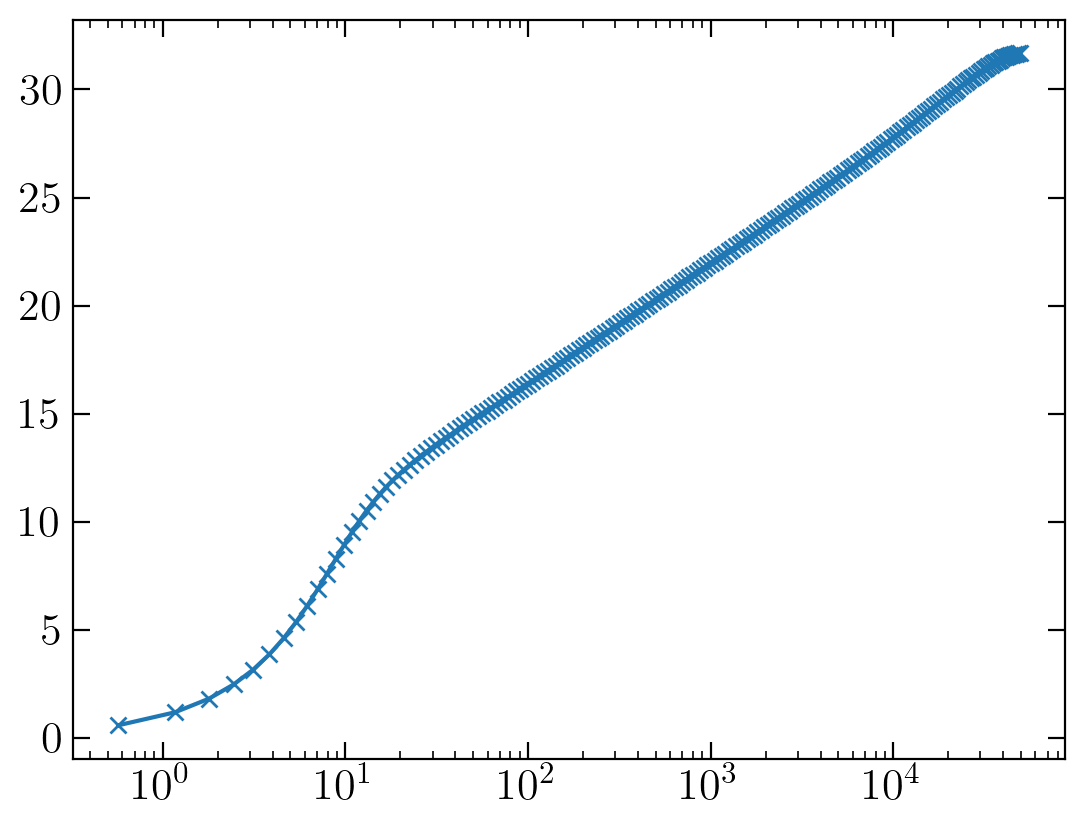

In [12]:
mesh = Mesh(400, 2, 9)

sol = solveRANS(mesh = mesh, ReTau = 50000, turbModel = "SA")

plt.semilogx(sol['ypl'][1:mesh.n//2], sol['u'][1:mesh.n//2], '-x')

# Example, V2F model for constant $Re^\star_\tau$ case from Patel et al. with different variable property corrections

ReTau  =  950.0
Pr     =  1.0
expRho =  -1.0
expMu  =  0.7
expLam =  0.0
Qvol   =  75.0
Index(['y', 'y+', 'y*', 'Ret*', 'Pr*', '<rho>', '<mu>', '<lambda>', '<u+>',
       '{u+}', 'uvd', 'u*', 'u*2', '<T>', '{T}', '<T+>', 'Tvd', 'T*',
       '<rho>{u"u"}', '<rho>{v"v"}', '<rho>{w"w"}', '<rho>{u"v"}',
       '<rho>{T"T"}', '<rho>{v"T"}', '<rho>{u"T"}', '<u'2>', '<v'2>', '<w'2>',
       '<T'2>', 'eps', 'tdif', 'vdif', 'epsSLS', 'prodSLS', 'transSLS',
       'compSLS', 'densSLS'],
      dtype='object')
CONVERGED! Iteration: 1066, Residual(u) = 9.97591227125649e-07, Time to run 1.8258 seconds
CONVERGED! Iteration: 1137, Residual(u) = 9.974086501740142e-07, Time to run 1.9759 seconds
CONVERGED! Iteration: 1282, Residual(u) = 9.965614195046851e-07, Time to run 2.1753 seconds


Text(0, 0.5, '$u^\\star$')

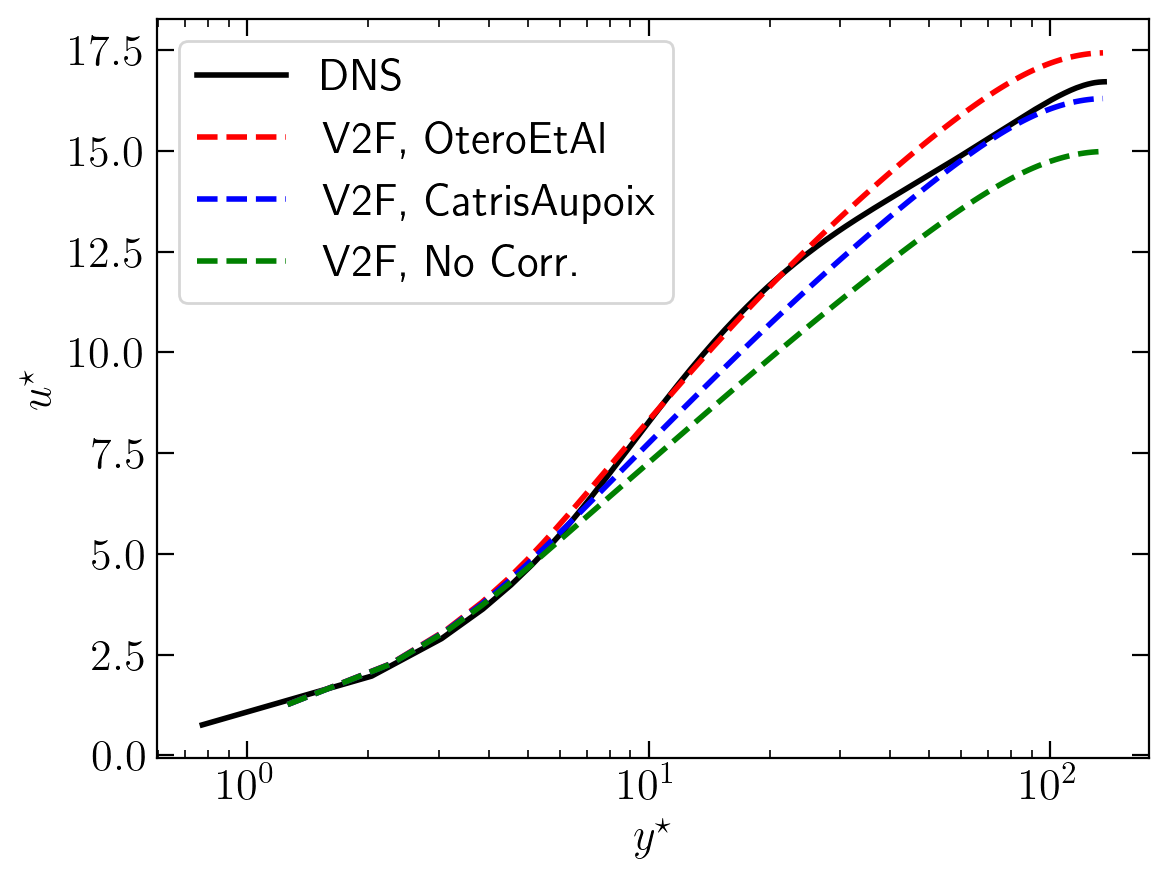

In [25]:
mesh = Mesh(200, 2, 4)


DNS = readAPdata("DNS_data/PatelEtAl_gasLike.txt")
# DNS = readAPdata("DNS_data/PatelEtAl_constReTauStar.txt")
# DNS = loadTLdata('DNS_data/M4.0R200_data.csv')

sol1 = solveRANS(mesh = mesh, 
                yDNS = DNS['y'], rhoDNS = DNS['rho'], muDNS = DNS['mu'], ReTau = DNS['ReTau'], 
                varPropCorrection = "OteroEtAl", 
                turbModel = "V2F")

sol2 = solveRANS(mesh = mesh, 
                yDNS = DNS['y'], rhoDNS = DNS['rho'], muDNS = DNS['mu'], ReTau = DNS['ReTau'], 
                varPropCorrection = "CatrisAupoix", 
                turbModel = "V2F")

sol3 = solveRANS(mesh = mesh, 
                yDNS = DNS['y'], rhoDNS = DNS['rho'], muDNS = DNS['mu'], ReTau = DNS['ReTau'], 
                varPropCorrection = "None", 
                turbModel = "V2F")

plt.semilogx(DNS['yst'], DNS['ust'], 'k-', label = 'DNS', lw=2)
plt.semilogx(sol1['yst'][1:mesh.n//2], sol1['ust'][1:mesh.n//2], 'r--', label = 'V2F, OteroEtAl', lw=2)
plt.semilogx(sol2['yst'][1:mesh.n//2], sol2['ust'][1:mesh.n//2], 'b--', label = 'V2F, CatrisAupoix', lw=2)
plt.semilogx(sol3['yst'][1:mesh.n//2], sol3['ust'][1:mesh.n//2], 'g--', label = 'V2F, No Corr.', lw=2)
plt.legend()
plt.xlabel(r'$y^\star$')
plt.ylabel(r'$u^\star$')

# Plots in book

In [27]:
def solve_SST_SA(DNS):

    # mk_corr = solveRANS(mesh = mesh, 
    #                  ReTau = ReTau, 
    #                  turbModel = "V2F", 
    #                  varPropCorrection = 1,
    #                  rhoDNS = rhoDNS, muDNS = muDNS)#, Pr=Pr, expRho=expRho, expMu=expMu, expLam=expLam, Qvol=Qvol)
    
    # mk_nocorr = solveRANS(mesh = mesh,
    #                  ReTau = ReTau, 
    #                  turbModel = "V2F", 
    #                  varPropCorrection = 0,
    #                  rhoDNS = rhoDNS, muDNS = muDNS)#, Pr=Pr, expRho=expRho, expMu=expMu, expLam=expLam, Qvol=Qvol)

    sst_corr = solveRANS(mesh = mesh, 
                     ReTau = DNS['ReTau'], 
                     turbModel = "SST", 
                     varPropCorrection = "OteroEtAl",
                     yDNS = DNS['y'], rhoDNS = DNS['rho'], muDNS = DNS['mu'])
    
    sst_nocorr = solveRANS(mesh = mesh,
                     ReTau = DNS['ReTau'], 
                     turbModel = "SST", 
                     varPropCorrection = "None",
                     yDNS = DNS['y'], rhoDNS = DNS['rho'], muDNS = DNS['mu'])
    
    sa_corr = solveRANS(mesh = mesh, 
                     ReTau = DNS['ReTau'], 
                     turbModel = "SA", 
                     varPropCorrection = "OteroEtAl",
                     yDNS = DNS['y'], rhoDNS = DNS['rho'], muDNS = DNS['mu'])
    
    sa_nocorr = solveRANS(mesh = mesh,
                     ReTau = DNS['ReTau'], 
                     turbModel = "SA", 
                     varPropCorrection = "None",
                     yDNS = DNS['y'], rhoDNS = DNS['rho'], muDNS = DNS['mu'])
    
    return {#'mk_corr':mk_corr,  'mk_nocorr':mk_nocorr, 
            'sst_corr':sst_corr, 'sst_nocorr':sst_nocorr, 
            'sa_corr':sa_corr,   'sa_nocorr':sa_nocorr}

In [28]:
mesh = Mesh(160, 2, 5)

DNS_crets = readAPdata("DNS_data/PatelEtAl_constReTauStar.txt")

res_crets = solve_SST_SA(DNS_crets)

ReTau  =  395.0
Pr     =  1.0
expRho =  -1.0
expMu  =  -0.5
expLam =  0.0
Qvol   =  95.0
CONVERGED! Iteration: 362, Residual(u) = 9.918862393391189e-07, Time to run 0.4274 seconds
CONVERGED! Iteration: 438, Residual(u) = 9.851670206794656e-07, Time to run 0.4810 seconds
CONVERGED! Iteration: 382, Residual(u) = 9.776235382025612e-07, Time to run 0.2755 seconds
CONVERGED! Iteration: 387, Residual(u) = 9.932355607097991e-07, Time to run 0.2784 seconds


In [29]:
DNS_gasl = readAPdata("DNS_data/PatelEtAl_gasLike.txt")

res_gasl = solve_SST_SA(DNS_gasl)

ReTau  =  950.0
Pr     =  1.0
expRho =  -1.0
expMu  =  0.7
expLam =  0.0
Qvol   =  75.0
CONVERGED! Iteration: 380, Residual(u) = 9.990114195519899e-07, Time to run 0.4438 seconds
CONVERGED! Iteration: 485, Residual(u) = 9.938314562284688e-07, Time to run 0.5343 seconds
CONVERGED! Iteration: 356, Residual(u) = 9.785439981426202e-07, Time to run 0.2616 seconds
CONVERGED! Iteration: 355, Residual(u) = 9.988113336700297e-07, Time to run 0.2548 seconds


In [30]:
DNS_TL = loadTLdata('DNS_data/M4.0R200_data.csv')

res_TL = solve_SST_SA(DNS_TL)

rhow  =  3.44921321
muw   =  0.0001
utau  =  0.0294984408
ReTau =  1017.46412
CONVERGED! Iteration: 371, Residual(u) = 9.751356787140738e-07, Time to run 0.4429 seconds
CONVERGED! Iteration: 452, Residual(u) = 9.924134562891814e-07, Time to run 0.4960 seconds
CONVERGED! Iteration: 370, Residual(u) = 9.971242568796228e-07, Time to run 0.2687 seconds
CONVERGED! Iteration: 374, Residual(u) = 9.820793787570595e-07, Time to run 0.2669 seconds


# Plot results

In [31]:
def plotProfiles(ax, res, color, dashes, DNS, label='', showDNS=True):
    
    # analytic results for viscous sub-layer
    ypLam = 10**np.linspace(np.log10(0.1),np.log10(13),20)
    ax.semilogx(ypLam,ypLam,color='0.6', lw=0.8, dashes=(10,2,2,2))
        
    # semi-empirical result for log-layer
    ypTurb = 10**np.linspace(np.log10(4),np.log10(1200),20) 
    upTurb = 1/0.41*np.log(ypTurb) + 5.2
    ax.semilogx(ypTurb, upTurb,color='0.6', lw=0.8, dashes=(10,2,2,2))

    # DNS
    # yst_ = 10**np.linspace(np.log10(DNS['yst'][1]), 0.9999*np.log10(DNS['yst'][-1]), 30)
    # def intp(a):
    #     f = int1d.interp1d(DNS['yst'], a)
    #     return f(yst_)

    mew = 1.0
    ms  = 6
    fillstyle = 'none'
    colorDNS = 'k'

    # ax.semilogx(yst_[1:], intp(ustDNS)[1:], 'o', color=color, fillstyle = fillstyle, mew=mew, ms = ms)
    if (showDNS):
        ax.semilogx(DNS['yst'][1:], DNS['ust'][1:], '-', color=colorDNS, lw=2, label='DNS')

    # Model 
    ax.semilogx(res['yst'][1:mesh.n//2], res['ust'][1:mesh.n//2], color=color, dashes=dashes, lw=2, label=label)

    ax.yaxis.set_minor_locator(MultipleLocator(1))

    

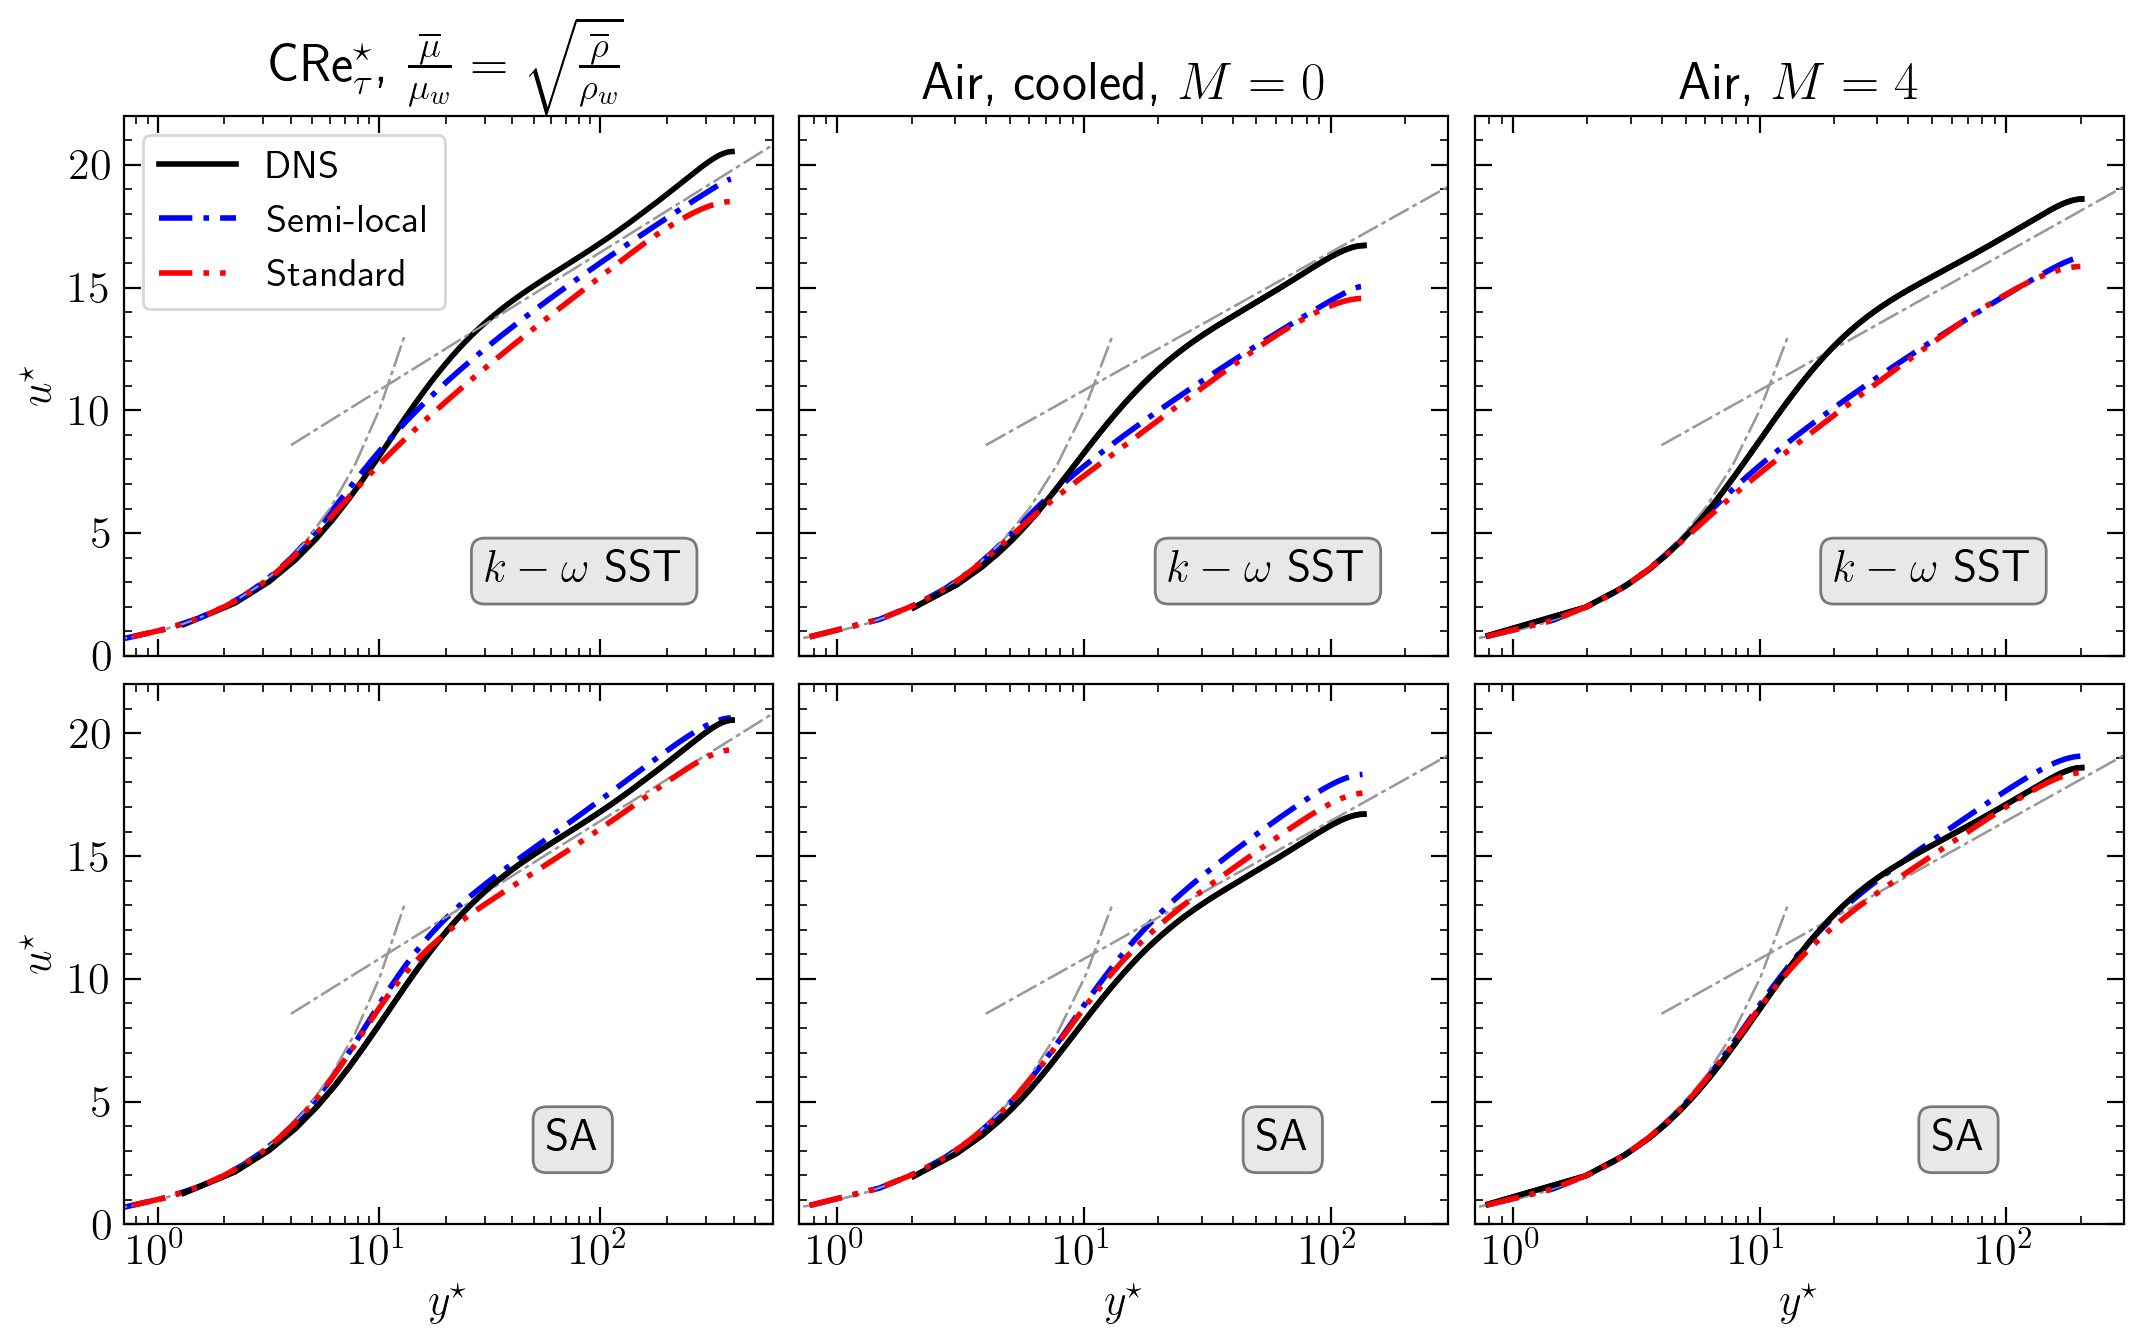

In [32]:
fig, ax = plt.subplots(2,3, figsize=(11, 7), sharex='col', sharey='row')
dashes1 = (6,2,1,2)
dashes2 = (6,2,1,2,1,2)
# plotProfiles(ax[0,0], res_crets['mk_corr'],   'b', dashes1, ystDNS_crets, ustDNS_crets)
# plotProfiles(ax[0,0], res_crets['mk_nocorr'], 'r', dashes2, ystDNS_crets, ustDNS_crets)

plotProfiles(ax[0,0], res_crets['sst_corr'],   'b', dashes1, DNS_crets, label='Semi-local')
plotProfiles(ax[0,0], res_crets['sst_nocorr'], 'r', dashes2, DNS_crets, label='Standard', showDNS=False)

plotProfiles(ax[1,0], res_crets['sa_corr'],   'b', dashes1, DNS_crets)
plotProfiles(ax[1,0], res_crets['sa_nocorr'], 'r', dashes2, DNS_crets)



# plotProfiles(ax[0,1], res_gasl['mk_corr'],   'b', dashes1, ystDNS_gasl, ustDNS_gasl)
# plotProfiles(ax[0,1], res_gasl['mk_nocorr'], 'r', dashes2, ystDNS_gasl, ustDNS_gasl)

plotProfiles(ax[0,1], res_gasl['sst_corr'],   'b', dashes1, DNS_gasl)
plotProfiles(ax[0,1], res_gasl['sst_nocorr'], 'r', dashes2, DNS_gasl)

plotProfiles(ax[1,1], res_gasl['sa_corr'],   'b', dashes1, DNS_gasl)
plotProfiles(ax[1,1], res_gasl['sa_nocorr'], 'r', dashes2, DNS_gasl)



# plotProfiles(ax[0,2], res_TL['mk_corr'],   'b', dashes1, yst_DNS_TL, ust_DNS_TL)
# plotProfiles(ax[0,2], res_TL['mk_nocorr'], 'r', dashes2, yst_DNS_TL, ust_DNS_TL)

plotProfiles(ax[0,2], res_TL['sst_corr'],   'b', dashes1, DNS_TL)
plotProfiles(ax[0,2], res_TL['sst_nocorr'], 'r', dashes2, DNS_TL)

plotProfiles(ax[1,2], res_TL['sa_corr'],   'b', dashes1, DNS_TL)
plotProfiles(ax[1,2], res_TL['sa_nocorr'], 'r', dashes2, DNS_TL)


ax[0,0].set_xlim(0.7, 600)
ax[0,1].set_xlim(0.7, 300)
ax[0,2].set_xlim(0.7, 300)

ax[0,0].set_ylim(0, 22)
ax[1,0].set_ylim(0, 22)
# ax[2,0].set_ylim(0, 22)

ax[0,0].set_ylabel(r'$u^\star$')
ax[1,0].set_ylabel(r'$u^\star$')

ax[1,0].set_xlabel(r'$y^\star$')
ax[1,1].set_xlabel(r'$y^\star$')
ax[1,2].set_xlabel(r'$y^\star$')



ax[0,0].set_title(r'CRe$^\star_\tau$, $\frac{\overline\mu}{\mu_w} = \sqrt{\frac{\overline\rho}{\rho_w}}$')
ax[0,1].set_title(r'Air, cooled, $M=0$')
ax[0,2].set_title(r'Air, $M=4$')

ax[0,0].legend(loc=2, fontsize=14)

props = dict(boxstyle='round', facecolor='lightgray', alpha=0.5)
ax[0,0].text(30, 3, r'$k-\omega$ SST', rotation=0, bbox=props)
ax[0,1].text(22, 3, r'$k-\omega$ SST', rotation=0, bbox=props)
ax[0,2].text(20, 3, r'$k-\omega$ SST', rotation=0, bbox=props)

ax[1,0].text(57, 3, r'SA', rotation=0, bbox=props)
ax[1,1].text(50, 3, r'SA', rotation=0, bbox=props)
ax[1,2].text(50, 3, r'SA', rotation=0, bbox=props)

plt.tight_layout(w_pad=0.6, h_pad=0.1)


In [20]:
fig.savefig('othermodels.pdf')

In [47]:
mesh = Mesh(200, 2, 6)

DNS_crets = readAPdata("DNS_data/PatelEtAl_constReTauStar.txt")

v2f_corr = solveRANS(mesh = mesh, 
                 ReTau = DNS_crets['ReTau'], 
                 turbModel = "V2F", 
                 varPropCorrection = "OteroEtAl",
                 yDNS = DNS_crets['y'], rhoDNS = DNS_crets['rho'], muDNS = DNS_crets['mu'])

v2f_nocorr = solveRANS(mesh = mesh,
                 ReTau = DNS_crets['ReTau'], 
                 turbModel = "V2F", 
                 varPropCorrection = "None",
                 yDNS = DNS_crets['y'], rhoDNS = DNS_crets['rho'], muDNS = DNS_crets['mu'])

ReTau  =  395.0
Pr     =  1.0
expRho =  -1.0
expMu  =  -0.5
expLam =  0.0
Qvol   =  95.0
CONVERGED! Iteration: 1036, Residual(u) = 9.94018681695229e-07, Time to run 1.8285 seconds
CONVERGED! Iteration: 1387, Residual(u) = 9.994941696242502e-07, Time to run 2.3986 seconds


In [48]:
DNS_gasl = readAPdata("DNS_data/PatelEtAl_gasLike.txt")

gasl_v2f_corr = solveRANS(mesh = mesh, 
                 ReTau = DNS_gasl['ReTau'], 
                 turbModel = "V2F", 
                 varPropCorrection = "OteroEtAl",
                 yDNS = DNS_gasl['y'], rhoDNS = DNS_gasl['rho'], muDNS = DNS_gasl['mu'])

gasl_v2f_nocorr = solveRANS(mesh = mesh,
                 ReTau = DNS_gasl['ReTau'], 
                 turbModel = "V2F", 
                 varPropCorrection = "None",
                 yDNS = DNS_gasl['y'], rhoDNS = DNS_gasl['rho'], muDNS = DNS_gasl['mu'])

ReTau  =  950.0
Pr     =  1.0
expRho =  -1.0
expMu  =  0.7
expLam =  0.0
Qvol   =  75.0
CONVERGED! Iteration: 873, Residual(u) = 9.871630200229427e-07, Time to run 1.5196 seconds
CONVERGED! Iteration: 1168, Residual(u) = 9.981683760398206e-07, Time to run 2.0180 seconds


In [49]:
DNS_TL = loadTLdata('DNS_data/M4.0R200_data.csv')

TL_v2f_corr = solveRANS(mesh = mesh, 
                 ReTau = DNS_TL['ReTau'], 
                 turbModel = "V2F", 
                 varPropCorrection = "OteroEtAl",
                 yDNS = DNS_TL['y'], rhoDNS = DNS_TL['rho'], muDNS = DNS_TL['mu'])

TL_v2f_nocorr = solveRANS(mesh = mesh,
                 ReTau = DNS_gasl['ReTau'], 
                 turbModel = "V2F", 
                 varPropCorrection = "None",
                 yDNS = DNS_TL['y'], rhoDNS = DNS_TL['rho'], muDNS = DNS_TL['mu'])

rhow  =  3.44921321
muw   =  0.0001
utau  =  0.0294984408
ReTau =  1017.46412
CONVERGED! Iteration: 834, Residual(u) = 9.996228136411192e-07, Time to run 1.4601 seconds
CONVERGED! Iteration: 974, Residual(u) = 9.890118744186452e-07, Time to run 1.6937 seconds


In [52]:
def plotProfilesAll(ax, res, color, dashes, DNS, label='', showDNS=True, plotepsDNS=True):

    # analytic results for viscous sub-layer
    ypLam = 10**np.linspace(np.log10(0.1),np.log10(13),20)
    ax[0].semilogx(ypLam,ypLam,color='0.6', lw=0.8, dashes=(10,2,2,2))
        
    # semi-empirical result for log-layer
    ypTurb = 10**np.linspace(np.log10(4),np.log10(1200),20) 
    upTurb = 1/0.41*np.log(ypTurb) + 5.2
    ax[0].semilogx(ypTurb, upTurb,color='0.6', lw=0.8, dashes=(10,2,2,2))

    # DNS
    # yst_ = 10**np.linspace(np.log10(ystDNS[1]), 0.9999*np.log10(ystDNS[-1]), 30)
    # def intp(a):
    #     f = int1d.interp1d(ystDNS, a)
    #     return f(yst_)
    mew = 1.0
    ms  = 6
    fillstyle = 'none'
    colorDNS = 'k'
    # ax.semilogx(yst_[1:], intp(ustDNS)[1:], 'o', color=color, fillstyle = fillstyle, mew=mew, ms = ms)
    if (showDNS):
        ax[0].semilogx(DNS['yst'][1:], DNS['ust'][1:], '-', color=colorDNS, lw=2, label='DNS')

    # Model 
    ax[0].semilogx(res['yst'][1:mesh.n//2], res['ust'][1:mesh.n//2], color=color, dashes=dashes, lw=2, label=label)


    # ruv 
    ax[1].semilogx(DNS['yst'][1:], DNS['ruv'][1:], '-', color=colorDNS, lw=2, label='DNS')
    ax[1].semilogx(res['yst'][1:mesh.n//2], res['ruv'][1:mesh.n//2], color=color, dashes=dashes, lw=2, label=label)

    
    # TKE 
    ax[2].semilogx(DNS['yst'][1:], DNS['rk'][1:], '-', color=colorDNS, lw=2, label='DNS')
    ax[2].semilogx(res['yst'][1:mesh.n//2], res['rho'][1:mesh.n//2]*res['k'][1:mesh.n//2], 
                   color=color, dashes=dashes, lw=2, label=label)
    

    # eps
    if plotepsDNS == True:
        # ystSLS = dnsSLS[:,0]*dnsSLS[:,1]
        # eps    = dnsSLS[:,2]/dnsSLS[:,1]
        ax[3].semilogx(DNS['yst'], DNS['epsSLS'], '-', color=colorDNS, lw=2, label='DNS')

    # DNSeps = eps[1:]
    # ax[3].semilogx(DNS['yst'][1:], DNS['eps'][1:], '-', color=colorDNS, lw=2, label='DNS')
    ReTS = np.sqrt(res['rho'])/res['mu']
    eps = res['rho']**1.5*res['e']/ReTS
    ax[3].semilogx(res['yst'][1:mesh.n//2], 
                   -eps[1:mesh.n//2], 
                   color=color, dashes=dashes, lw=2, label=label)
    

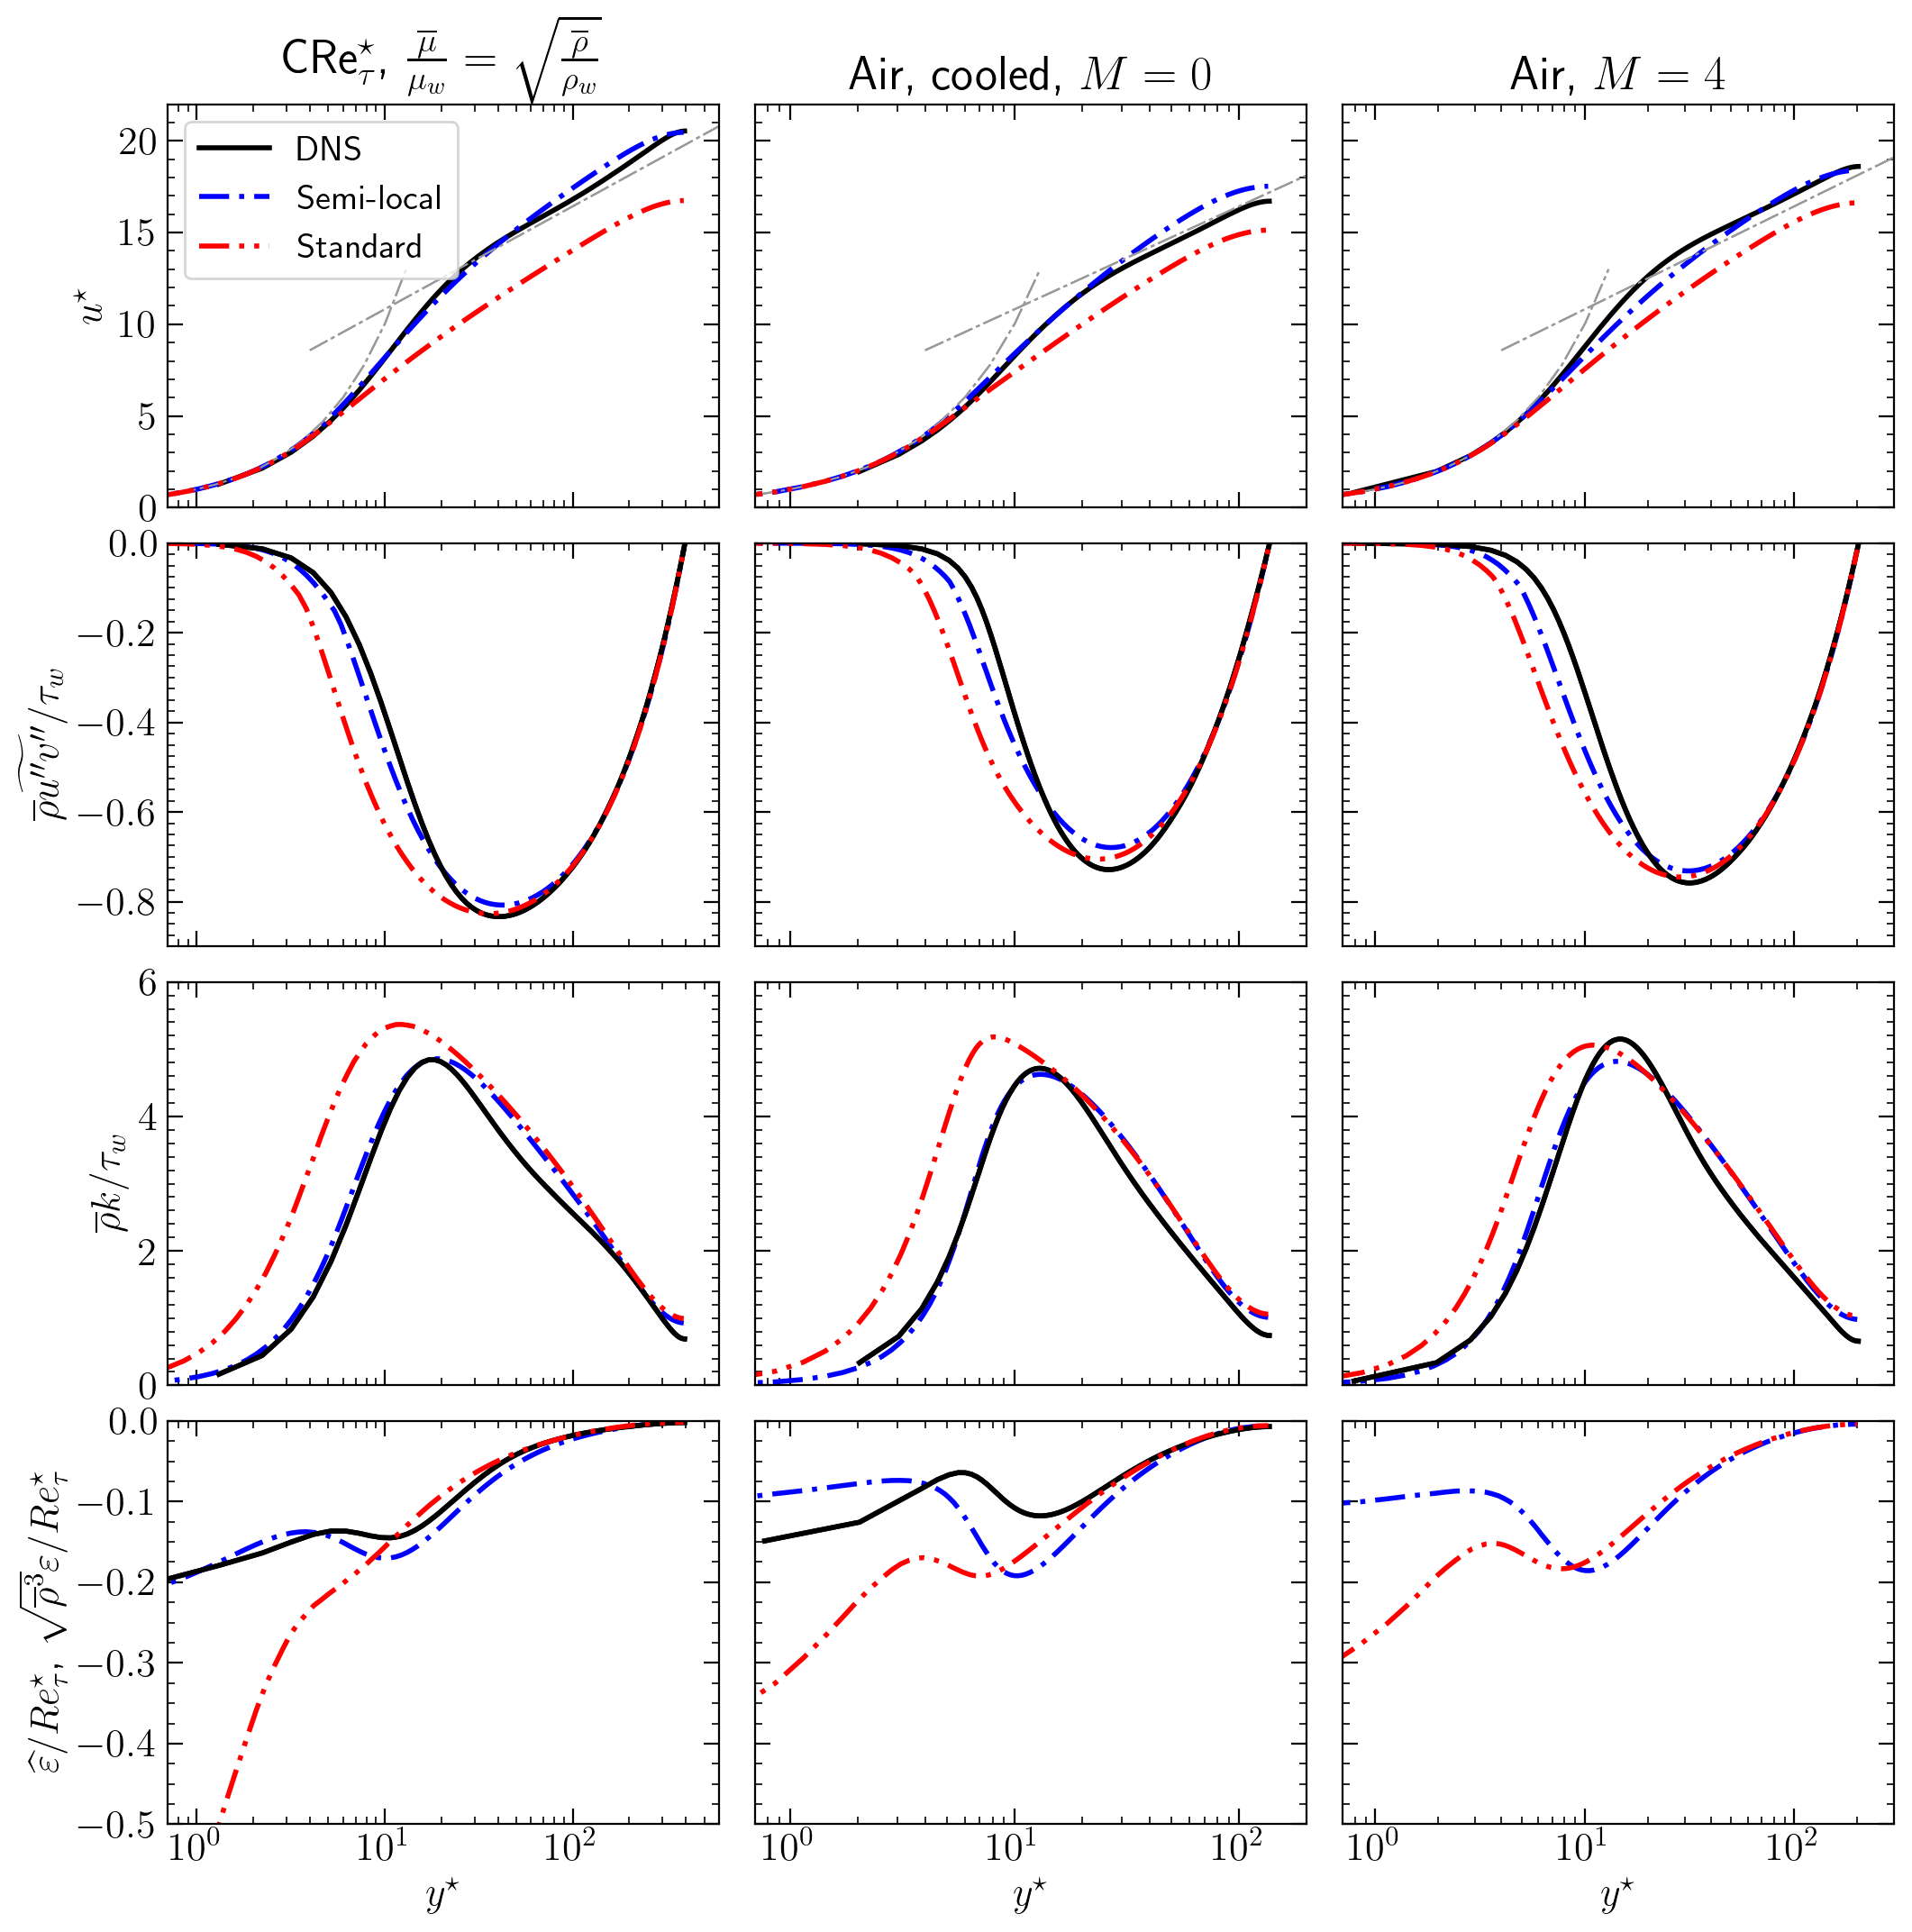

In [53]:
fig, ax = plt.subplots(4,3, figsize=(11, 11), sharex='col', sharey='row')
dashes1 = (6,2,1,2)
dashes2 = (6,2,1,2,1,2)

plotProfilesAll(ax[:,0], v2f_corr,   'b', dashes1, DNS_crets, label='Semi-local')
plotProfilesAll(ax[:,0], v2f_nocorr, 'r',  dashes2, DNS_crets, label='Standard', showDNS=False)

plotProfilesAll(ax[:,1], gasl_v2f_corr,   'b', dashes1, DNS_gasl, label='Semi-local')
plotProfilesAll(ax[:,1], gasl_v2f_nocorr, 'r',  dashes2, DNS_gasl, label='Standard', showDNS=False)

# dnsSLS = np.loadtxt('gl2/kbudsl2')

plotProfilesAll(ax[:,2], TL_v2f_corr,   'b', dashes1, DNS_TL, label='Semi-local', plotepsDNS=False)
plotProfilesAll(ax[:,2], TL_v2f_nocorr, 'r',  dashes2, DNS_TL, label='Standard', showDNS=False, plotepsDNS=False)



ax[0,0].set_title(r'CRe$^\star_\tau$, $\frac{\overline\mu}{\mu_w} = \sqrt{\frac{\overline\rho}{\rho_w}}$')
ax[0,1].set_title(r'Air, cooled, $M=0$')
ax[0,2].set_title(r'Air, $M=4$')

ax[0,0].set_xlim(0.7, 600)
ax[0,1].set_xlim(0.7, 200)
ax[0,2].set_xlim(0.7, 300)

ax[0,0].set_ylim(0, 22)
ax[1,0].set_ylim(-0.9, 0)
ax[2,0].set_ylim(0, 6)
ax[3,0].set_ylim(-0.5, 0)

ax[0,0].set_ylabel(r'$u^\star$')
ax[1,0].set_ylabel(r'$\overline\rho \widetilde{u^{\prime\prime} v^{\prime\prime}}/\tau_w$')
ax[2,0].set_ylabel(r'$\overline\rho k/\tau_w$')
ax[3,0].set_ylabel(r'$\widehat\varepsilon/Re^\star_\tau$, $\sqrt{\overline\rho^3}\varepsilon/Re^\star_\tau$')


ax[3,0].set_xlabel(r'$y^\star$')
ax[3,1].set_xlabel(r'$y^\star$')
ax[3,2].set_xlabel(r'$y^\star$')

ax[0,0].legend(loc=2, fontsize=14)


ax[0,0].yaxis.set_minor_locator(MultipleLocator(1))
ax[1,0].yaxis.set_minor_locator(MultipleLocator(0.025))
ax[2,0].yaxis.set_minor_locator(MultipleLocator(0.2))
ax[3,0].yaxis.set_minor_locator(MultipleLocator(0.025))


plt.tight_layout(w_pad=0.9, h_pad=0.0)


In [54]:
fig.savefig('resultsV2F.pdf')